In [44]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn import cluster
from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline
from __future__ import division
import random
import math
import xml.etree.ElementTree
import json

import geoplotlib
from geoplotlib.utils import BoundingBox

In [171]:
# DEFINES

DEBUG = True
def log(s):
    if DEBUG:
        print s
        
EXTRACT_ALLEKONTROLRESULTATER = False

# Extract or load allekontrolresultater.xml to csv

In [172]:
if EXTRACT_ALLEKONTROLRESULTATER:
    # Load
    e = xml.etree.ElementTree.parse('../data/allekontrolresultater.xml').getroot()

    # Extract
    df = []
    for row in e.findall('row'):
        #print pd.DataFrame.from_dict([row.attrib])
        df.append(pd.DataFrame.from_dict([row.attrib]))
    df = pd.concat(df3)

    # Save
    df.to_csv('../data/allekontrolresultater.csv', encoding="utf-8")
else:
    df = pd.read_csv('../data/allekontrolresultater.csv')
    
df.head()

,Unnamed: 0,By,Elite_Smiley,Geo_Lat,Geo_Lng,Kaedenavn,URL,adresse1,branche,brancheKode,cvrnr,fjerdeseneste_kontrol,fjerdeseneste_kontrol_dato,naestseneste_kontrol,naestseneste_kontrol_dato,navn1,navnelbnr,pixibranche,pnr,postnr,
0,0,Hvidovre,0,55.636857,12.479992,NaN,http://www.findsmiley.dk/da-DK/Searching/Detai...,Hvidovrevej 279,"Dagligvareforretninger, letfordærvelige fødevarer",47.11.00.A,27091326,1,2011-03-29T13:14:00,2,2014-02-11T00:00:00,"Hvidovrevejens Minimarked,",100332829,Dagligvarer,1009790728,2650,...
1,0,Hårby,1,55.223351,10.123197,SuperBrugsen,http://www.findsmiley.dk/da-DK/Searching/Detai...,Algade 41,"Dagligvareforretninger, letfordærvelige fødevarer",47.11.00.A,37176117,1,2009-08-03T14:40:00,1,2013-06-12T00:00:00,SuperBrugsen Dagligvarer,80202233,Dagligvarer,1003052316,5683,...
2,0,Karise,0,55.270005,12.220344,NaN,http://www.findsmiley.dk/da-DK/Searching/Detai...,Vemmetoftevej 2C,"Dagligvareforretninger, letfordærvelige fødevarer",47.11.00.A,18455994,1,2013-12-11T00:00:00,2,2015-08-06T00:00:00,Lægårdens Minimarked,534601,Dagligvarer,1003444738,4653,...
3,0,Fakse,0,55.258005,12.119786,NaN,http://www.findsmiley.dk/da-DK/Searching/Detai...,Torvegade 20,"Dagligvareforretninger, letfordærvelige fødevarer",47.11.00.A,36932902,NaN,NaN,NaN,NaN,Firkløveren,575181,Dagligvarer,1020510575,4640,...
4,0,Hirtshals,1,57.562734,10.029374,Kwik Spar,http://www.findsmiley.dk/da-DK/Searching/Detai...,"Allingdamvej 1, Åbyen","Dagligvareforretninger, letfordærvelige fødevarer",47.11.00.A,16086533,1,2011-06-17T00:00:00,1,2014-02-04T00:00:00,KWIK SPAR,10364136,Dagligvarer,1001032059,9850,...


# Initial data exploration

In [46]:
def numAndPrc(x, tot):
    return "%s, (%.1f%%)" % (x,100*x/tot)

print "Number of records: %i" % len(df)
print "Records with cvr number: " + numAndPrc(sum(df.cvrnr.map(math.isnan)==False), len(df))
print "of these unique cvr numbers: " + numAndPrc(len(set(df.cvrnr)), sum(df.cvrnr.map(math.isnan)==False))

lat = df.Geo_Lat
lon = df.Geo_Lng
mask = (lat.map(math.isnan) == False) & (lat != 0)
print "Records with geo code: " + numAndPrc(sum(mask),len(df))

kontroller = np.sum(df[['seneste_kontrol','naestseneste_kontrol','tredjeseneste_kontrol','fjerdeseneste_kontrol']]
       .applymap(math.isnan) == False, axis=0)
print "Total records: %s" % sum(kontroller)
print "Records with one check: " + numAndPrc(kontroller.seneste_kontrol, len(df))
print "Records with two checks: " + numAndPrc(kontroller.naestseneste_kontrol, len(df))
print "Records with three checks: " + numAndPrc(kontroller.tredjeseneste_kontrol, len(df))
print "Records with four checks: " + numAndPrc(kontroller.fjerdeseneste_kontrol, len(df))
print "Records with elite smiley: " + numAndPrc(sum(df.Elite_Smiley == 1), len(df))
print "Smileys given %s" % Counter(df[['seneste_kontrol','naestseneste_kontrol','tredjeseneste_kontrol','fjerdeseneste_kontrol']].stack())
print "Top represented cities: %s" % Counter(df.By).most_common()[0:10]


Number of records: 57179
Records with cvr number: 56372, (98.6%)
of these unique cvr numbers: 34482, (61.2%)
Records with geo code: 54972, (96.1%)
Total records: 182008
Records with one check: 53255, (93.1%)
Records with two checks: 47539, (83.1%)
Records with three checks: 42699, (74.7%)
Records with four checks: 38515, (67.4%)
Records with elite smiley: 26762, (46.8%)
Smileys given Counter({1.0: 167302, 2.0: 12940, 4.0: 1360, 3.0: 406})
Top represented cities: [('K\xc3\xb8benhavn K', 1673), ('K\xc3\xb8benhavn V', 1174), ('\xc3\x85rhus C', 1161), ('K\xc3\xb8benhavn S', 1076), ('K\xc3\xb8benhavn \xc3\x98', 1037), ('Aalborg', 916), ('Odense C', 856), ('K\xc3\xb8benhavn N', 853), (nan, 744), ('Roskilde', 727)]


In [201]:
len(Counter(df.pixibranche))


47

In [17]:
df.loc[df.By == 'Albertslund']

,Unnamed: 0,By,Elite_Smiley,Geo_Lat,Geo_Lng,Kaedenavn,URL,adresse1,branche,brancheKode,cvrnr,fjerdeseneste_kontrol,fjerdeseneste_kontrol_dato,naestseneste_kontrol,naestseneste_kontrol_dato,navn1,navnelbnr,pixibranche,pnr,postnr,
359,0,Albertslund,1,55.678823,12.347206,Nærkøb,http://www.findsmiley.dk/da-DK/Searching/Detai...,Galgebakken Torv 2,"Dagligvareforretninger, letfordærvelige fødevarer",47.11.00.A,16911143,1,2013-05-27T00:00:00,1,2015-03-09T00:00:00,Galgebakkens Købmand,100692425,Dagligvarer,1004690794,2620,...
686,0,Albertslund,0,55.670176,12.338895,SuperBrugsen,http://www.findsmiley.dk/da-DK/Searching/Detai...,"Egelundsvej 20, Herstedvester","Dagligvareforretninger, letfordærvelige fødevarer",47.11.00.A,65184818,1,2013-03-04T00:00:00,4,2015-04-14T00:00:00,SuperBrugsen Dagligvarer,100218920,Dagligvarer,1003159112,2620,...
977,0,Albertslund,1,55.662973,12.368756,NaN,http://www.findsmiley.dk/da-DK/Searching/Detai...,Roskildevej 25-27,"Engroshandel og oplagring, ikke specialiseret,...",46.39.00.C,26259495,1,2014-05-19T00:00:00,1,2015-03-06T00:00:00,Coop Danmark A/S Speciallager,100330491,Lagre og grossister uden produktion,1003075764,2620,...
992,0,Albertslund,0,55.685285,12.370883,NaN,http://www.findsmiley.dk/da-DK/Searching/Detai...,Herstedøster Skolevej 4,"Vin og spiritus, engroshandel, registreret",46.34.20,30239741,NaN,NaN,1,2013-12-17T00:00:00,Happywine,534277,Lagre og grossister uden produktion,1012997740,2620,...
1091,0,Albertslund,1,55.656871,12.357879,NaN,http://www.findsmiley.dk/da-DK/Searching/Detai...,Nordmarks Alle 2,"Servering: Kantiner mv., fast personkreds over...",56.29.00.A,66137112,1,2010-02-08T12:54:00,1,2012-10-10T00:00:00,"Albertslund Kommune Rådhus, Kantine",100300478,"Restauranter, pizzeriaer, kantiner m.m.",1003266711,2620,...
1232,0,Albertslund,0,NaN,NaN,NaN,http://www.findsmiley.dk/da-DK/Searching/Detai...,Kanalens Kvt 132-134,"Dagligvareforretninger, letfordærvelige fødevarer",47.11.00.A,30286375,1,2013-01-25T00:00:00,2,2014-04-14T00:00:00,Let Køb,503054,Dagligvarer,NaN,2620,...
1385,0,Albertslund,1,NaN,NaN,NaN,http://www.findsmiley.dk/da-DK/Searching/Detai...,Hedemarksvej 8,"Dagligvareforretninger, letfordærvelige fødevarer",47.11.00.A,36905891,1,2014-04-01T00:00:00,1,2015-03-12T00:00:00,Albertslund Bazar ApS,568460,Dagligvarer,1020435891,2620,...
1610,0,Albertslund,0,55.661970,12.360781,NaN,http://www.findsmiley.dk/da-DK/Searching/Detai...,Roskildevej 65,"Dagligvareforretninger, letfordærvelige fødevarer",47.11.00.A,26259495,NaN,NaN,NaN,NaN,Coop Madkassen Butik,555417,Dagligvarer,1003228443,2620,...
1850,0,Albertslund,0,55.657873,12.337035,NaN,http://www.findsmiley.dk/da-DK/Searching/Detai...,Hedemarksvej 58,"Dagligvareforretninger, letfordærvelige fødevarer",47.11.00.A,35280766,NaN,NaN,1,2014-02-19T00:00:00,Yasmin Købmand,539240,Dagligvarer,1018922793,2620,...
1904,0,Albertslund,0,55.670865,12.339351,Netto,http://www.findsmiley.dk/da-DK/Searching/Detai...,"Egelundsvej 24, Vest Center","Dagligvareforretninger, letfordærvelige fødevarer",47.11.00.A,35954716,1,2012-02-08T00:00:00,1,2014-05-26T00:00:00,Netto 7715,100183146,Dagligvarer,1007545718,2620,...


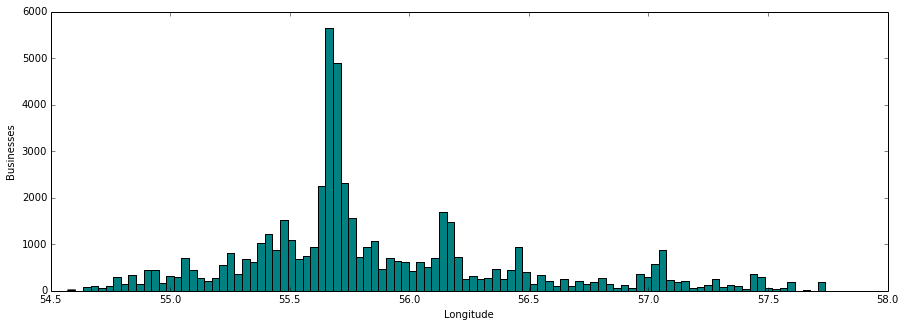

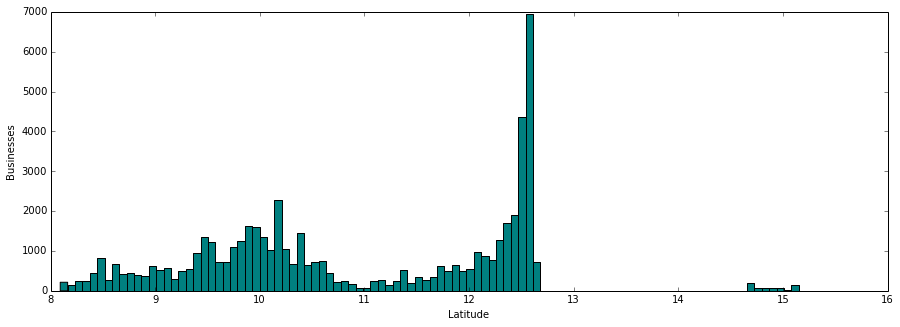

In [119]:
plt.figure(figsize=(15,5))
plt.hist(lat.loc[mask].tolist(), 100, color='teal');
plt.xlabel("Longitude");
plt.ylabel("Businesses");
plt.figure(figsize=(15,5))
plt.hist(lon.loc[mask].tolist(), 100, color='teal');
plt.xlabel("Latitude");
plt.ylabel("Businesses");

In [113]:
geodata = {"lat": lat.loc[mask],
           "lon": lon.loc[mask]}
geoplotlib.dot(geodata, color='k');

geoplotlib.tiles_provider('toner-lite');
geoplotlib.set_bbox(BoundingBox(max(geodata['lat']), max(geodata['lon']), min(geodata['lat']), min(geodata['lon'])));
geoplotlib.show();

In [223]:
#df.loc[df.Elite_Smiley.map(math.isnan)]

In [21]:
geodata = {"lat": lat.loc[mask & (df.seneste_kontrol > 1)],
           "lon": lon.loc[mask & (df.seneste_kontrol > 1)]}
geoplotlib.dot(geodata, color='k');

geoplotlib.tiles_provider('toner-lite');
geoplotlib.set_bbox(BoundingBox(max(geodata['lat']), max(geodata['lon']), min(geodata['lat']), min(geodata['lon'])));
geoplotlib.show();

Different smileys given


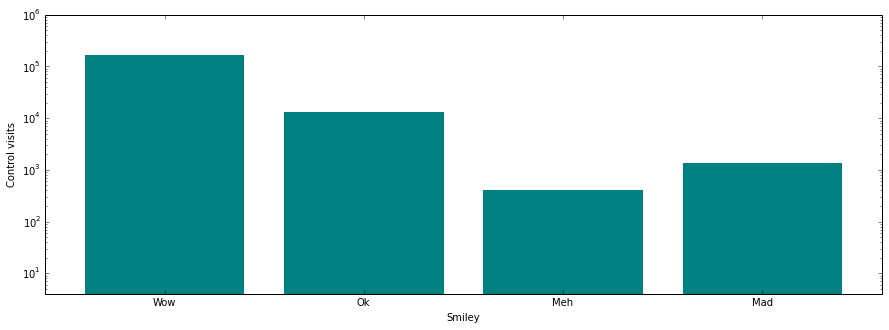

In [107]:
kontroller = df[['seneste_kontrol','naestseneste_kontrol','tredjeseneste_kontrol','fjerdeseneste_kontrol']]
print "Different smileys given"
v = Counter(kontroller.stack()).values()
plt.figure(figsize=(15,5))
plt.bar([0.6, 1.6, 2.6, 3.6],v, [0.8,0.8,0.8,0.8],4, log = True, color='teal', edgecolor='none');
plt.ylim([0,1e6])
plt.xlim([0.4,4.6])
plt.xticks([1,2,3,4], ['Wow','Ok','Meh','Mad']);
plt.ylabel('Control visits');
plt.xlabel('Smiley');


42 businesses 


[('', 38),
 ('aps', 8),
 ('ivs', 6),
 ('slikkepinden', 4),
 ('-', 3),
 ('candy', 2),
 ('og', 2),
 ('marked', 2),
 ('&', 2),
 ('bazar', 2),
 ('kiosk', 2),
 ('dagligvarer', 2),
 ('bageri', 2),
 ('ulige', 1),
 ('i/s', 1),
 ('kolls&ko', 1),
 ('a/s', 1),
 ('k\xc3\xb8b', 1),
 ('danmark', 1),
 ('nordisk', 1),
 ('p\xc3\xb8lsevogn', 1),
 ('zahraa', 1),
 ('slikhans', 1),
 ('royal', 1),
 ('kolding', 1),
 ('5621', 1),
 ('\xc3\x98lgrethe', 1),
 ('reg.nr.:dg', 1),
 ('\xc3\x98lby', 1),
 ('slikhj\xc3\xb8rnet', 1),
 ('get', 1),
 ('pitstop', 1),
 ('kosttilskud', 1),
 ('dan', 1),
 ('v/rodin', 1),
 ('international', 1),
 ('sonati', 1),
 ('candybox', 1),
 ('rebalance', 1),
 ('fiskebil', 1),
 ('chuck', 1),
 ('choconord', 1),
 ('pizza', 1),
 ('bulgarien', 1),
 ('hobro', 1),
 ('skive', 1),
 ('aarhus', 1),
 ('burger', 1),
 ('export', 1),
 ('ahmad', 1),
 ('import', 1),
 ('viaduktbageriet', 1),
 ('broker', 1),
 ('n\xc3\xa6stved', 1),
 ('active', 1),
 ('super', 1),
 ('cherry', 1),
 ('r.', 1),
 ('93125', 1),
 ('ze

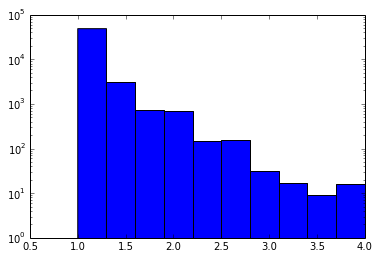

In [200]:

rating = df[['seneste_kontrol','naestseneste_kontrol','tredjeseneste_kontrol','fjerdeseneste_kontrol']].astype(float).mean(axis=1)

names = df.loc[rating>3].navn1.str.lower().str.split(" ")

plt.hist(rating.loc[rating.isnull() == False], log=True);
flattened = [word for name in names for word in name]
print "%s businesses " % len(names)
Counter(flattened).most_common()


In [198]:
df.loc[rating > 3][['navn1','adresse1','By','seneste_kontrol','naestseneste_kontrol','tredjeseneste_kontrol','fjerdeseneste_kontrol']]

,navn1,adresse1,By,seneste_kontrol,naestseneste_kontrol,tredjeseneste_kontrol,fjerdeseneste_kontrol
893,Ølby Bazar Kolonial,Ølbycenter 17,Køge,4,2,4,4
1468,Dan køb v/Rodin Ahmad,Dumpen 20,Viborg,1,4,4,4
2235,Istanbul Bazar Dagligvarer,Frederiksborgvej 17-19,København NV,4,4,4,4
2598,Bulgarien Import Export I/S,"Åboulevard 32, st",København N,4,4,4,4
2797,SUPER SPAR Dagligvarer,Persillehaven 111,Herlev,1,4,4,4
6272,Zamani Fiskebil Reg.nr.:DG 93125,Østervej 63,Glostrup,4,4,1,4
6435,Al Zahraa Marked,Nørrebrogade 249,København N,4,4,4,2
7566,JRZ International Broker v/ Johan R. Zerlang,"Palægade 5, 4",København K,4,NaN,NaN,NaN
8758,Mobis Danmark ApS,Grønttorvet 6,Valby,4,3,NaN,NaN
8874,FMK Food,Gjellerupvej 102,Brabrand,3,4,NaN,NaN


In [192]:
Counter([x[0:4] for x in df.fjerdeseneste_kontrol_dato if type(x) is str])

Counter({'2000': 1,
         '2002': 1,
         '2003': 11,
         '2004': 288,
         '2005': 370,
         '2006': 379,
         '2007': 447,
         '2008': 947,
         '2009': 2776,
         '2010': 5092,
         '2011': 4366,
         '2012': 7199,
         '2013': 7658,
         '2014': 6414,
         '2015': 2643,
         '2016': 8})

In [ ]:
# geocode api
#http://maps.google.com/maps/api/geocode/json?&components=country:DK&address=jensen

In [234]:
# Weight histogram
mask = (rating.map(math.isnan)==False)
Counter(rating.loc[mask].tolist())

Counter({1.0: 41158,
         1.25: 7221,
         1.3333333333333333: 879,
         1.5: 2198,
         1.6666666666666667: 140,
         1.75: 580,
         2.0: 706,
         2.25: 111,
         2.3333333333333335: 40,
         2.5: 107,
         2.6666666666666665: 7,
         2.75: 39,
         3.0: 31,
         3.25: 14,
         3.3333333333333335: 3,
         3.5: 9,
         3.75: 3,
         4.0: 13})

In [ ]:
# Branche med værst smileyer

In [343]:
mask = (rating.map(math.isnan)==False)
brancheSmiley = pd.concat([df.pixibranche, rating], axis=1)
brancheSmiley.columns = ['branche', 'rating']
brancheSmiley = brancheSmiley.loc[mask]

df2 = []
for branche in set(df.pixibranche):
    mask2 = brancheSmiley.branche == branche
    df2.append([branche, np.mean(brancheSmiley.rating.loc[mask2]), sum(mask2)])
    
df2 = pd.DataFrame(df2, columns=['branche','rating','antal'])

In [349]:
print df2.sort(['rating'],ascending = [False])

                                              branche    rating  antal
32    Virksomheder, engros-branche endnu ikke tildelt  1.364286     70
21    Virksomheder, detail-branche endnu ikke tildelt  1.279245    265
17                           Salater, dressinger m.m.  1.166667     15
1                         Frugt- og grøntforretninger  1.150433    308
37                              Værtshuse og bodegaer  1.144336   1948
24                          Bagere og bagerafdelinger  1.135153   1145
39               Chokolade- og konfektureforretninger  1.131705    696
19                                                 Æg  1.125000      4
0                                         Dagligvarer  1.120332   5079
33                                    Vinforretninger  1.118114    472
16                                Brød, kager og kiks  1.110380    114
45                          Apoteker og materialister  1.103749    947
42                                            Kiosker  1.101400   1559
14    

In [348]:
mask = df.branche == 'Fart\xc3\xb8jer: Fabriksfart\xc3\xb8jer'
df.loc[mask]

,Unnamed: 0,By,Elite_Smiley,Geo_Lat,Geo_Lng,Kaedenavn,URL,adresse1,branche,brancheKode,cvrnr,fjerdeseneste_kontrol,fjerdeseneste_kontrol_dato,naestseneste_kontrol,naestseneste_kontrol_dato,navn1,navnelbnr,pixibranche,pnr,postnr,
5598,0,Thyborøn,1,56.700002,8.208884,NaN,http://www.findsmiley.dk/da-DK/Searching/Detai...,Havnegade 62,Fartøjer: Fabriksfartøjer,10.20.20.D,33178808,1,2012-11-28T00:00:00,1,2014-09-24T00:00:00,L 120 Linette,30706278,Fabriksfartøjer,1016387912,7680,...
5616,0,Neksø,0,55.062263,15.133714,NaN,http://www.findsmiley.dk/da-DK/Searching/Detai...,Strandgade 10,Fartøjer: Fabriksfartøjer,10.20.20.D,17631047,1,2014-11-06T00:00:00,2,2016-01-25T00:00:00,"M/TR ""Ocean Tiger"" V/Partsrederiet Ocean Tiger...",10364319,Fabriksfartøjer,1001327733,3730,...


In [281]:
# Predict next smiley
kontroller = df[['tredjeseneste_kontrol','fjerdeseneste_kontrol']]#,'tredjeseneste_kontrol','fjerdeseneste_kontrol']]
for checkRating in range(1,5):
    print "\n%u:" % checkRating
    mask = (kontroller.iloc[:,1] == checkRating) & (kontroller.iloc[:,0].map(math.isnan)==False)
    n = sum(mask)
    print "n = %u" % n
    print [x/n for x in Counter(kontroller.iloc[:,0].loc[mask]).values()]



1:
n = 34563
[0.91097416312241419, 0.08338396551225298, 0.0014466336834186848, 0.0041952376819141858]

2:
n = 3436
[0.82072176949941789, 0.11816065192083819, 0.012514551804423749, 0.048603026775320142]

3:
n = 129
[0.75193798449612403, 0.093023255813953487, 0.093023255813953487, 0.062015503875968991]

4:
n = 382
[0.7172774869109948, 0.11518324607329843, 0.015706806282722512, 0.15183246073298429]


0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
...
57164    1
57165    1
57166    1
57167    1
57168    1
57169    1
57170    1
57171    1
57172    1
57173    1
57174    1
57175    1
57176    1
57177    1
57178    1
Name: seneste_kontrol, Length: 57179, dtype: float64


In [22]:
# Area of geojson polygon
from math import pi, sin

WGS84_RADIUS = 6378137

def rad(value):
    return value * pi / 180

def ring__area(coordinates):
    """
    Calculate the approximate _area of the polygon were it projected onto
        the earth.  Note that this _area will be positive if ring is oriented
        clockwise, otherwise it will be negative.
    Reference:
        Robert. G. Chamberlain and William H. Duquette, "Some Algorithms for
        Polygons on a Sphere", JPL Publication 07-03, Jet Propulsion
        Laboratory, Pasadena, CA, June 2007 http://trs-new.jpl.nasa.gov/dspace/handle/2014/40409
    @Returns
    {float} The approximate signed geodesic _area of the polygon in square meters.
    """

    assert isinstance(coordinates, list)

    _area = 0
    coordinates_length = len(coordinates)

    if coordinates_length > 2:
        for i in range(0, coordinates_length):
            if i == (coordinates_length - 2):
                lower_index = coordinates_length - 2
                middle_index = coordinates_length - 1
                upper_index = 0
            elif i == (coordinates_length - 1):
                lower_index = coordinates_length - 1
                middle_index = 0
                upper_index = 1
            else:
                lower_index = i
                middle_index = i + 1
                upper_index = i + 2

            p1 = coordinates[lower_index]
            p2 = coordinates[middle_index]
            p3 = coordinates[upper_index]

            _area += (rad(p3[0]) - rad(p1[0])) * sin(rad(p2[1]))

        _area = _area * WGS84_RADIUS * WGS84_RADIUS / 2

    return _area

def polygon__area(coordinates):

    assert isinstance(coordinates, list)

    _area = 0
    if len(coordinates) > 0:
        _area += abs(ring__area(coordinates[0]))

        for i in range(1, len(coordinates)):
            _area -= abs(ring__area(coordinates[i]))

    return _area


def area(geometry):

    if isinstance(geometry, str):
        geometry = json.loads(geometry)

    assert isinstance(geometry, dict)

    _area = 0

    if geometry['type'] == 'Polygon':
        return polygon__area(geometry['coordinates'])
    elif geometry['type'] == 'MultiPolygon':
        for i in range(0, len(geometry['coordinates'])):
            _area += polygon__area(geometry['coordinates'][i])

    elif geometry['type'] == 'GeometryCollection':
        for i in range(0, len(geometry['geometries'])):
            _area += area(geometry['geometries'][i])

    return _area

In [239]:
# Load data
with open('../data/postnumre2008-07-01.geojson') as data_file:    
    mapdata = json.load(data_file)

befolkning = pd.read_csv('../data/PNR1_2005_befolkning.csv')

# Extract postnummer
befolkning['Postnummer'] = [int(s[0:4]) for s in befolkning.Navn]

# Match postnummer and extend geojson data
for feature in mapdata['features']:
    # Extract groups of postnummer and sum data
    pgroup = feature['properties']['Name'].split(' - ')
    if (len(pgroup) > 1):
        mask = (int(pgroup[0]) <= befolkning.Postnummer) & (befolkning.Postnummer <= int(pgroup[1]))
        smvirk = sum((int(pgroup[0]) <= df.postnr) & (df.postnr <= int(pgroup[1])))
    else:
        mask = befolkning.Postnummer == int(pgroup[0])
        smvirk = sum(df.postnr == int(pgroup[0]))
    
    # clean and extend geojson
    feature['properties']['Indbyggere']  = sum(befolkning.loc[mask].Indbyggere)
    feature['properties']['Description'] = feature['properties']['Description'].split('<td>')[1].split('</td>')[0]
    feature['properties']['Areal']       = area(feature['geometry'])/1e6
    feature['properties']['SmileyVirksomheder'] = smvirk

with open('../data/postnumre_clean.geojson', 'w') as fp:
    json.dump(mapdata, fp)

In [238]:
for feature in mapdata['features']:
    # Extract groups of postnummer and sum data
    pgroup = feature['properties']['Name'].split(' - ')
    if (len(pgroup) > 1):
        mask = (int(pgroup[0]) <= df.postnr) & (df.postnr <= int(pgroup[1]))
    else:
        mask = df.postnr == int(pgroup[0]);
    ppa = feature['properties']['Indbyggere']/feature['properties']['Areal']
    ipa = sum(mask)/feature['properties']['Areal']
    
    print feature['properties']['Description']
    print ppa/ipa


København K
19.9080525414
København V
34.4983193277
Frederiksberg C
96.224025974
Frederiksberg
86.8393854749
København Ø
77.0395371263
København N
83.01992966
København S
88.5120817844
København NV
92.4205020921
København SV
65.4979253112
Valby
81.5587188612
Glostrup
66.005730659
Brøndby
63.198757764
Rødovre
115.636363636
Albertslund
128.178217822
Vallensbæk
174.833333333
Taastrup
82.6868686869
Ishøj
98.5837320574
Hedehusene
100.859375
Hvidovre
101.586419753
Brøndby Strand
144.142857143
Vallensbæk Strand
109.609375
Greve
121.636363636
Solrød
152.037735849
Karlslunde
80.3608247423
Brønshøj
125.472560976
Vanløse
119.232931727


KeyboardInterrupt: 

In [237]:
mapdata['features'][300]

{u'geometry': {u'coordinates': [[[9.46674826035124, 55.1172665252028, 0.0],
    [9.46635956054999, 55.1164773903911, 0.0],
    [9.46558021042464, 55.1166108316568, 0.0],
    [9.4631036653331, 55.117034829711, 0.0],
    [9.46228156428559, 55.1209519540889, 0.0],
    [9.4585511935768, 55.1150728025728, 0.0],
    [9.46245950516199, 55.1148588394916, 0.0],
    [9.45335676111085, 55.1097471381795, 0.0],
    [9.4295051042086, 55.1122538878833, 0.0],
    [9.41772208181228, 55.0988766535643, 0.0],
    [9.37188869200625, 55.0882765543014, 0.0],
    [9.35325103772788, 55.0418010198675, 0.0],
    [9.35786595619829, 55.0305027951729, 0.0],
    [9.37670137735867, 55.0278354810635, 0.0],
    [9.3851387782313, 55.022141394755, 0.0],
    [9.36456529113935, 55.0050949602446, 0.0],
    [9.34054163004907, 55.007974419967, 0.0],
    [9.33794842799707, 55.0108099217585, 0.0],
    [9.34640857441704, 55.0133376783748, 0.0],
    [9.33656785955283, 55.0145968148349, 0.0],
    [9.33403007790739, 55.011183629437